In [1]:
# practice data 1
import pandas as pd
import numpy as np
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = df["x1"] + df["x2"] + np.random.rand(len(df))
df.head()

,x1,x2,y
0,7.0,0.0,7.644463
1,6.0,2.0,8.233394
2,8.0,2.0,10.984513
3,0.0,2.0,2.455789
4,5.0,0.0,5.444074


In [4]:
# gbq: google big query
df.to_gbq("cs544-f23.test2.samp1", if_exists="replace")

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


In [6]:
from google.cloud import bigquery

In [7]:
%load_ext google.cloud.bigquery

In [8]:
bq = bigquery.Client()

In [15]:
%%bigquery
CREATE OR REPLACE TABLE test2.traintest

AS

SELECT x1,x2,y,rand() < 0.25 AS test
FROM test2.samp1

Query is running:   0%|          |

""


In [19]:
%%bigquery
CREATE OR REPLACE MODEL test2.lr
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

select x1,x2,y
from test2.traintest
where NOT test

Query is running:   0%|          |

""


In [20]:
%%bigquery
SELECT *
FROM ML.WEIGHTS(MODEL test2.lr)

Query is running:   0%|          |

Downloading:   0%|          |

,processed_input,weight,category_weights
0,x1,0.996044,[]
1,x2,0.995255,[]
2,__INTERCEPT__,0.562305,[]


In [23]:
%%bigquery
SELECT *
FROM ML.PREDICT(MODEL test2.lr, (
    select x1,x2,y
    from test2.traintest
    where test
))

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_y,x1,x2,y
0,0.562305,0.0,0.0,0.886027
1,4.546479,4.0,0.0,4.350839
2,5.542522,5.0,0.0,5.962096
3,5.542522,5.0,0.0,5.444074
4,5.542522,5.0,0.0,5.935327
5,7.534609,7.0,0.0,7.644463
6,8.530653,8.0,0.0,8.359521
7,2.552814,0.0,2.0,2.869272
8,2.552814,0.0,2.0,2.407483
9,6.536988,4.0,2.0,6.740694


In [26]:
%%bigquery df
SELECT *
FROM ML.EVALUATE(MODEL test2.lr, (
    select x1,x2,y
    from test2.traintest
    where test
))

Query is running:   0%|          |

Downloading:   0%|          |

In [28]:
df.at[0, "r2_score"]

0.9895126456631314

# Transformers

In [29]:
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = 2 * df["x1"] ** 2 - 3 * df["x2"] + np.random.rand(len(df))
df.head()

,x1,x2,y
0,0.0,1.0,-2.999554
1,4.0,0.0,32.267233
2,4.0,1.0,29.599615
3,9.0,1.0,159.489365
4,9.0,2.0,156.328200


In [30]:
df.to_gbq("cs544-f23.test2.tbl1")

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8019.70it/s]


In [31]:
%%bigquery
CREATE OR REPLACE MODEL test2.m1
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

select x1,x2,y
from test2.tbl1

Query is running:   0%|          |

""


In [33]:
%%bigquery df
SELECT *
FROM ML.EVALUATE(MODEL test2.m1, (
    select x1,x2,y
    from test2.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

In [34]:
df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,11.085638,182.017106,0.068616,9.707725,0.932886,0.932886


In [38]:
%%bigquery
select x1, POWER(x1, 2) AS x1_2, x2, POWER(x2, 2) AS x2_2, y
from test2.tbl1

LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,x1,x1_2,x2,x2_2,y
0,0.0,0.0,0.0,0.0,0.133452
1,2.0,4.0,0.0,0.0,8.885280
2,2.0,4.0,0.0,0.0,8.899905
3,2.0,4.0,0.0,0.0,8.868594
4,3.0,9.0,0.0,0.0,18.213731


In [39]:
%%bigquery
CREATE OR REPLACE MODEL test2.m2
TRANSFORM(x1, POWER(x1, 2) AS x1_2, x2, POWER(x2, 2) AS x2_2, y)
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

select x1,x2,y
from test2.tbl1

Query is running:   0%|          |

""


In [41]:
%%bigquery
SELECT *
FROM ML.EVALUATE(MODEL test2.m2, (
    select x1,x2,y
    from test2.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.242454,0.078081,0.001278,0.238254,0.999971,0.999971


# compare m1 to m2

In [44]:
%%bigquery df
SELECT "m1" as model, r2_score
FROM ML.EVALUATE(MODEL test2.m1, (
    select x1,x2,y
    from test2.tbl1
))
UNION ALL
SELECT "m2" as model, r2_score
FROM ML.EVALUATE(MODEL test2.m2, (
    select x1,x2,y
    from test2.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

In [45]:
df

,model,r2_score
0,m2,0.999971
1,m1,0.932886


Text(0, 0.5, 'R^2 Score')

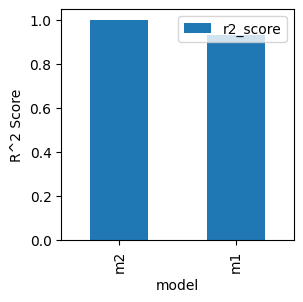

In [48]:
ax = df.set_index("model").plot.bar(figsize=(3,3))
ax.set_ylabel("R^2 Score")

In [49]:
# practice data 2
df = pd.DataFrame({"x1": np.random.choice(["A", "B", "C"], 100), 
                   "x2": np.random.randint(0, 10, 100).astype(float)})
df["y"] = df["x1"].map({"A":1, "B":5, "C":15}) + 2 * df["x2"] + np.random.rand(len(df))
df.head(3)

,x1,x2,y
0,A,1.0,3.914656
1,C,9.0,33.680635
2,B,9.0,23.474259


In [50]:
df.to_gbq("cs544-f23.test2.tbl2")

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3666.35it/s]


In [52]:
%%bigquery
CREATE MODEL test2.m3
OPTIONS(model_type="LINEAR_REG", input_label_cols=["y"])

AS

SELECT x1,x2,y
FROM test2.tbl2

Query is running:   0%|          |

""


In [53]:
%%bigquery
SELECT "m3" as model, r2_score
FROM ML.EVALUATE(MODEL test2.m3, (
    select x1,x2,y
    from test2.tbl2
))

Query is running:   0%|          |

Downloading:   0%|          |

,model,r2_score
0,m3,0.99877


In [55]:
%%bigquery df 
SELECT *
FROM ML.WEIGHTS(MODEL test2.m3)

Query is running:   0%|          |

Downloading:   0%|          |

In [56]:
df

,processed_input,weight,category_weights
0,x1,NaN,"[{'category': 'C', 'weight': 10.00693718824802..."
1,x2,1.987481,[]
2,__INTERCEPT__,5.581663,[]


In [60]:
w = df.set_index("processed_input").at["x1", "category_weights"].tolist()
w

[{'category': 'C', 'weight': 10.006937188248026},
 {'category': 'A', 'weight': -4.027650622846319},
 {'category': 'B', 'weight': 0.0}]

In [62]:
weights = pd.DataFrame(w)
weights

,category,weight
0,C,10.006937
1,A,-4.027651
2,B,0.000000


<Axes: xlabel='category'>

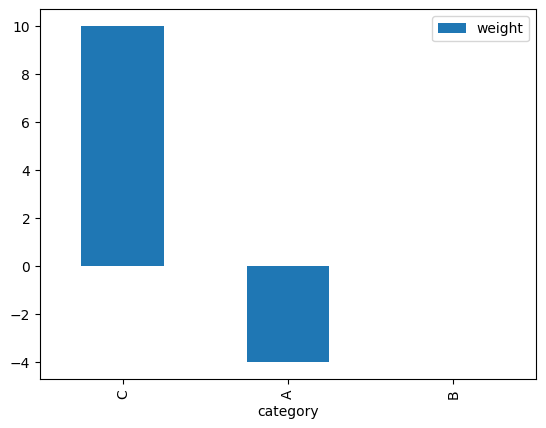

In [64]:
weights.set_index("category").plot.bar()